### Entities & Aspect Mining : An example of heuristic approach

This workshop illustrates two tasks. 
1. To illustrate the extraction of dependencies and triples. It is very useful for extracting granular information from a document. 
2. To extract 'sentiment-related' words on the aspects to generate their aspects scores. 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import packages
import spacy
import numpy as np
from spacy import displacy
import pickle as pk
from os import getcwd
import pandas as pd
import json

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 11.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# You may mount your Google drive where the data files are held.
#from google.colab import drive
#drive.mount('/content/drive')

#Alternatively, upload the data file to this Colab session temporarily.

Mounted at /content/drive


## First Task : extraction of triples (dependencies)

These sample reviews were extracted from Yelp for a Chinese restaurant (only 21 of them for illustration).

In [ ]:
# replace the file path with one appropriate for your drive
df_reviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NMSM/data/Reviews_DTF.txt', sep = '\t', names=["reviews"])
df_reviews

,reviews
0,I love this place. I visit this place (or one ...
1,"Must try: xiao long bao, chili crab bun, fried..."
2,Highly recommend trying the chili sauce also. ...
3,For those who are not familiar with asian food...
4,This Din Tai Fung is located on the 4th floor ...
5,The staff at the entrance gave me a number and...
6,Staffs were all friendly and attentive. I like...
7,FOOD 4/5 The legendary xiao long bao (steamed ...
8,AMBIENCE 3/5 It was noisy but I did not expect...
9,"STAFFS 5/5 Staffs were attentive, helpful and ..."


We'll use spacy to do the dependency parsing. In Colab, you don't need to download the spacy models.

In [ ]:
#!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [ ]:
#let's pick a review
eg=0
print(df_reviews["reviews"][eg])
#process it using spacy
doc = nlp(df_reviews["reviews"][eg])
for idno, sentence in enumerate(doc.sents):
    print ('Sentence {}:'.format(idno + 1), sentence)


I love this place. I visit this place (or one of the other din tai fung outlets) at least once a month. 
Sentence 1: I love this place.
Sentence 2: I visit this place (or one of the other din tai fung outlets) at least once a month.


A review has one or more sentences. It's often assumed that a sentence has one target and one sentiment, but it's not always like that.
Let's take look at the dependency information sentence by sentence.

In [ ]:
for sent in doc.sents:
    print ("------")
    for token in sent:
        print(token.text, token.dep_, token.head.text, token.head.pos_,
              [child for child in token.children])


------
I nsubj love VERB []
love ROOT love VERB [I, place, .]
this det place NOUN []
place dobj love VERB [this]
. punct love VERB []
------
I nsubj visit VERB []
visit ROOT visit VERB [I, place, once, .]
this det place NOUN []
place dobj visit VERB [this, (, or, one]
( punct place NOUN []
or cc place NOUN []
one conj place NOUN [of, )]
of prep one NUM [outlets]
the det outlets NOUN []
other amod outlets NOUN []
din compound tai PROPN []
tai compound outlets NOUN [din]
fung compound outlets NOUN []
outlets pobj of ADP [the, other, tai, fung]
) punct one NUM []
at advmod least ADJ []
least advmod once ADV [at]
once advmod visit VERB [least, month]
a det month NOUN []
month npadvmod once ADV [a]
. punct visit VERB []


In [ ]:
# visualize the dependencies.
displacy.render(doc.sents, style='dep', jupyter=True, options = { 'distance':80 })

Let's look at the breakdown of a sentence in detail. In this sentence, where is the root of the sentence, where everything is joined together? However, it is possible that sometimes due to the sentence structure there may be no root in the results.
We can filter for specific dependencies in the result.

In [ ]:
def getDep(sentence, rel):
    deps=[]
    print ("Input sentence is: " + str(sentence))
    for tok in sentence:
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text) # 提供我们需要的dependency
        print(dep)
        deps.append(dep)
    result = list(filter(lambda x : x[1]==rel or x[1].find(rel)!=-1, deps))
    if len(result) == 0 : return 999
    return result

sentence = "John likes the apple."
found = getDep(nlp(sentence), "obj")
print ("The result is :" + str(found))

Input sentence is: John likes the apple.
('John', 'nsubj', '---> ', 'likes')
('likes', 'ROOT', '---> ', 'likes')
('the', 'det', '---> ', 'apple')
('apple', 'dobj', '---> ', 'likes')
('.', 'punct', '---> ', 'likes')
The result is :[('apple', 'dobj', '---> ', 'likes')]


We can also use the dependency information to extract 'triples'. The predicate can come from the root or a clause without its own object/subject. The noun subject would be 'nsubj', and the object usually follow as 'dobj'. Putting it altogether, and we get a triple.

In [ ]:
def getTriple(sentence):
    deps=[]
    for tok in sentence:  
        dep =  (tok.text, tok.dep_, "---> ", tok.head.text)
        deps.append(dep)
    subj = list(filter(lambda x : x[1]=="nsubj", deps))
    obj = list(filter(lambda x : x[1]=="dobj", deps))
    root = list(filter(lambda x : x[1]=="ROOT" , deps))

    try: 
        triple = (subj[0][0], root[0][0], obj[0][0])
    except IndexError:
        print ("Pattern incorrect. No triples for " + str(sentence)) # rules needed to be written to extract some triples
        print ("The dependencies are: " + str(deps))
        return None
    return triple

triples=[]
s = "John likes big apple. The apple is delicious."
#doing it sentence by sentence
for sentence in nlp(s).sents:
  triple = getTriple(sentence)  # obtain triples in that sentence
  print ("Triple is " + str(triple))
  triples.append(triple)


Triple is ('John', 'likes', 'apple')
Pattern incorrect. No triples for The apple is delicious.
The dependencies are: [('The', 'det', '---> ', 'apple'), ('apple', 'nsubj', '---> ', 'is'), ('is', 'ROOT', '---> ', 'is'), ('delicious', 'acomp', '---> ', 'is'), ('.', 'punct', '---> ', 'is')]
Triple is None


## Extraction of aspect and entities

As taught in class, the extraction of entities/aspects and their sentiment scores is often done in a semi-supervised way. A 'mapping function' is often used to group the aspect expressions into the aspect categories in the domain. In the case of restaurants, the usual aspect categories are 'food', 'service' and 'price'. 

In [ ]:
# aspect categories
# From Frequency approach
aspect = {"food": ["xiao long bao", "noodles", "food", "dumplings", "pork", "flavour", "chili", 
                   "dishes", "lunch", "bun", "shrimp", "dimsum", "rice", "chicken"],
        "service" : ["staff", "wait", "water", "queue" ],
        "price" : ["price", "cost"]   }
# Let's also use a category 'overall' to cover everything else    

# Helper function for categorising aspects:
# Here the input is output from Spacy
def aspectCat(sentence):
    category=[]
    for tok in sentence:
        tok = tok.text.lower()
        for key, val in aspect.items():
            if tok in val: category.append(key)
    if len(category) == 0 : category.append("overall")
    return category

Next, we'll use Vader to do sentiment classification of sentences. You can always replace it with another classifier with better performance.

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
#Vader returns 4 scores. We take the 'compound' score as overall sentiment for the sentence.
res = analyzer.polarity_scores("but the price is expensive.")
res

{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0}

Given a review, for each sentence, we get its sentiment score and aspect category.

In [ ]:
result_sents =[] 

def getSentiment(span):
    res = analyzer.polarity_scores(span.text)
    senti = np.round(res['compound'],2)
    return (senti)

ex=0
doc = nlp(df_reviews["reviews"][ex])
for idx, sentence in enumerate(doc.sents):
    #print (sentence)
    res = getSentiment(sentence)

    try:
        cat = aspectCat(sentence)      
        result_sents.append({"scores":res, "text":sentence, "category":cat})
    except IndexError:
        # there are no specific aspects talked about. Just in general
        result_sents.append({"scores":res, "text":sentence, "category":"overall"})

for s in result_sents:
  print(s)

{'scores': 0.64, 'text': I love this place., 'category': ['overall']}
{'scores': 0.0, 'text': I visit this place (or one of the other din tai fung outlets) at least once a month., 'category': ['overall']}


Let's do it for the whole set of reviews and do a summarisation. 

In [ ]:
reviews = {}
for i in range(len(df_reviews["reviews"])):
    doc = nlp(df_reviews["reviews"][i])
    review_sents =[] 
    for idx, sentence in enumerate(doc.sents):
        #print (sentence)
        res = getSentiment(sentence)

        try:
            cat = aspectCat(sentence)      
            review_sents.append({"scores":res, "text":sentence.text, "category":cat})
        except IndexError:
            review_sents.append({"scores":res, "text":sentence.text, "category":"overall"})
    reviews[i]=review_sents

# summarise all reviews
summary_scores = {"overall":[], "service":[], "price":[], "food":[]}
# count total no of 
for item in reviews.items():
    for ResultList in item[1]:
        score = ResultList["scores"]
        for CatList in ResultList["category"]:
            summary_scores[CatList].append(score)

# for each category, summarize how many reviews are positive, negative respectively
print (summary_scores)
for key, val in summary_scores.items():
    #avg = round(np.mean(val),2)
    pos = np.sum(np.array(val) >= 0, axis=0)
    neg = np.sum(np.array(val) < 0, axis=0)
    summary_scores[key]={"pos":pos,"neg": neg, "Total": pos + neg}
#summary_scores["total no of reviews"]=len(reviews)

df_summary = pd.DataFrame(summary_scores)
df_summary=df_summary.transpose()

{'overall': [0.64, 0.0, -0.04, 0.42, 0.44, -0.34, 0.49, 0.88, 0.88, 0.3, 0.59, 0.0, -0.18, 0.45, 0.0, 0.42, 0.44, 0.59, 0.0, 0.79, 0.93, 0.36, 0.62, 0.0, 0.0, 0.0, 0.46, 0.64, 0.64, 0.0, -0.18, 0.59], 'service': [0.47, 0.08, 0.43, 0.0, 0.0], 'price': [0.42, 0.62, 0.27], 'food': [0.0, 0.0, 0.0, 0.0, 0.0, 0.42, 0.61, 0.61, 0.61, 0.0, 0.0, 0.0, 0.0, 0.48, 0.0, 0.0, 0.71, 0.56, 0.32, 0.32, 0.61, 0.64, 0.42, 0.53, 0.53, 0.0, 0.03, 0.62, 0.0, 0.48, 0.48, 0.72, 0.48, 0.77, -0.08, -0.08, 0.79, 0.79, 0.74, 0.74, -0.48, -0.08, 0.0, 0.27, 0.56, 0.0]}


In [ ]:
df_summary

,pos,neg,Total
overall,28,4,32
service,5,0,5
price,3,0,3
food,42,4,46


In [ ]:
#add two new columns into the table
df_summary["category"] = df_summary.index
#represent overall sentiment for the categary based on num of pos/neg
df_summary["sentiment"] = np.round((df_summary["pos"]-df_summary["neg"])/(df_summary["neg"]+df_summary["pos"]),2)


In [ ]:
df_summary

,pos,neg,Total,category,sentiment
overall,28,4,32,overall,0.75
service,5,0,5,service,1.00
price,3,0,3,price,1.00
food,42,4,46,food,0.83


Notice that for most of the time, the reviewers are talking mostly about the food quality. 

Finally the last step to present the information visually. Here a treemap with color representing sentiment is appropriate. The implementation is however quite wieldy in Python. 

In [ ]:
!pip install squarify
import squarify
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.5, 1.0, 'Sentiment Heat Map of Restaurant Aspects')

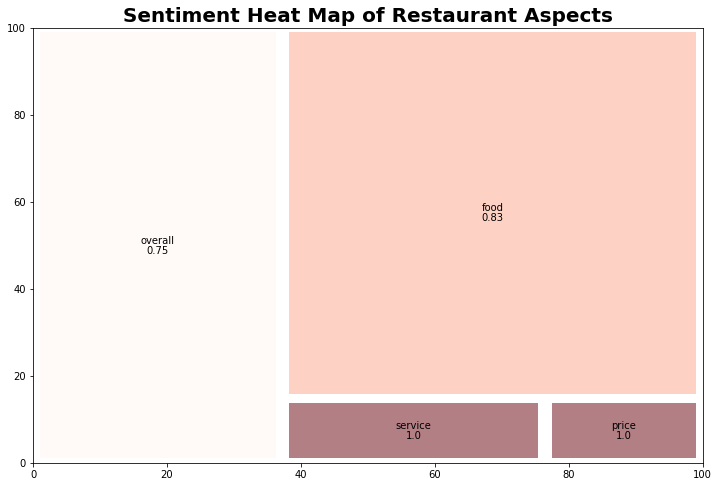

In [ ]:
norm = matplotlib.colors.Normalize(vmin=min(df_summary.sentiment), vmax=max(df_summary.sentiment))
colors = [matplotlib.cm.Reds(norm(value)) for value in df_summary.sentiment]

fig = plt.gcf()
fig.set_size_inches(12, 8)

#Use squarify to plot our data, label it and add colours. We add an alpha layer to ensure black labels show through
# Also used color intensity to reflect the sentiment value. 
squarify.plot(label=df_summary.category,sizes=df_summary.Total, value = df_summary.sentiment,color = colors, alpha=.5, pad =True)
plt.title("Sentiment Heat Map of Restaurant Aspects",fontsize=20,fontweight="bold")

### Conclusion
This example illustrates how the reviews are categorised and sentiment classified based on 3 aspect categories - food, price and service, with the rest as overall.

There are many ways to improve on it. This includes:
 - using lemmatization to identify mapped words
 - integrating with consistuency parsing to obtain NP chunks
 - using customized sentiment classifier
 - using co-reference resolution. The latter is useful as many of the pronouns like 'it', 'they'  have no identified targets in the subsequent sentences. They should similarly be mapped to the relevant entities and aspects.

### Exercise

- Perform the same exercise on another set of data - this time for rows of the airline sentiment data. What are the difficulties that you face? What aspects (and groups) do you consider in this case (heuristically)?